<a id = "1"></a><br>
# Load Python Pakages


In [1]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, f1_score, fbeta_score, auc, balanced_accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, RocCurveDisplay, confusion_matrix, recall_score

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#Stacking & ensembling
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier



random_state = 42


<a id = "2"></a><br>
#  First look to data

In [2]:
# Read the data
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv', index_col=[0])
submission_df = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
original = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv', index_col=[0])
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv', index_col=[0])

original.index.names = ['id']


train_df = train.copy()
submission_df = submission_df.copy()
original_df = original.copy()

train_df = pd.concat([train_df, original_df])

train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175034 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175034 non-null  int64  
 1   Surname          175034 non-null  object 
 2   CreditScore      175034 non-null  int64  
 3   Geography        175034 non-null  object 
 4   Gender           175034 non-null  object 
 5   Age              175034 non-null  float64
 6   Tenure           175034 non-null  int64  
 7   Balance          175034 non-null  float64
 8   NumOfProducts    175034 non-null  int64  
 9   HasCrCard        175034 non-null  float64
 10  IsActiveMember   175034 non-null  float64
 11  EstimatedSalary  175034 non-null  float64
 12  Exited           175034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 18.7+ MB


### Check for missing values

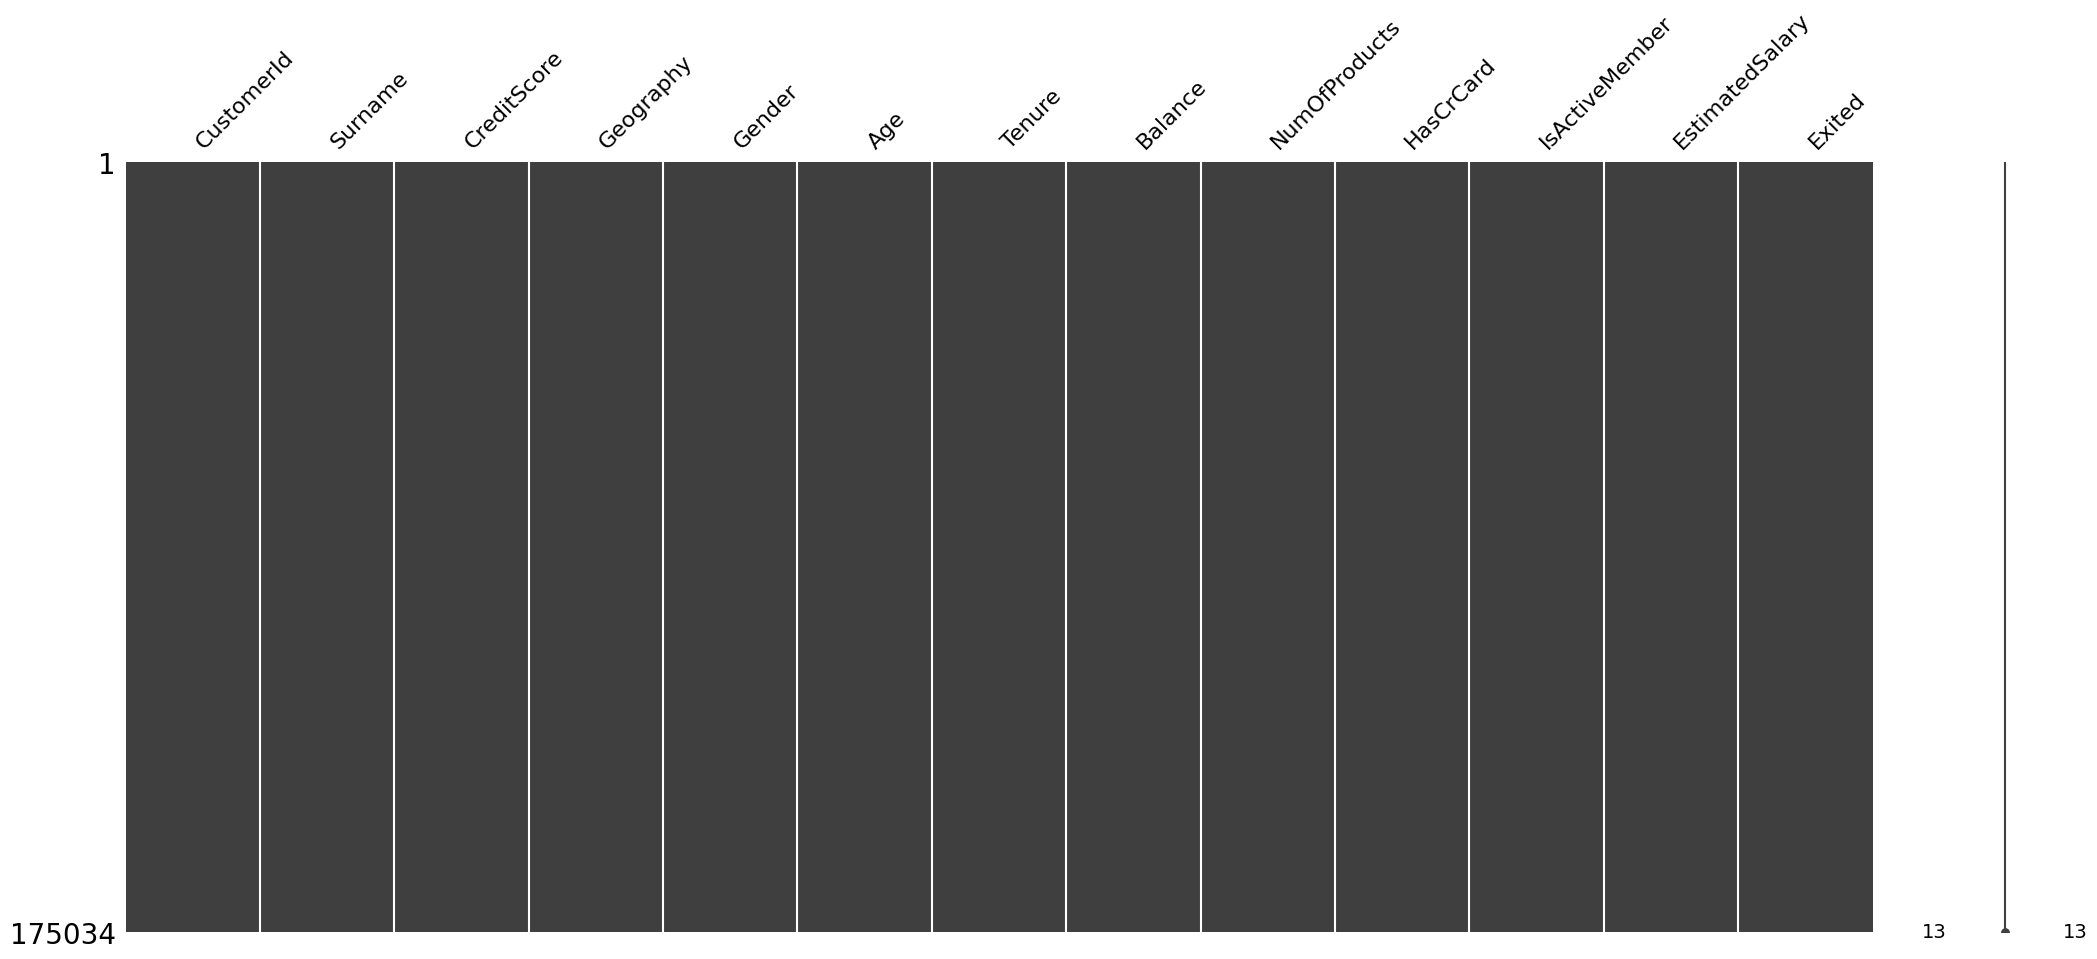

In [4]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

In [5]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,missing_count,missing_percent


There is no missing value...

<a id = "3"></a><br>
## Descpriptive statistics

In [6]:
#numerical feature descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,175034.0,1.569194e+07,71428.904538,15565701.00,15632882.00,15690169.00,1.575666e+07,15815690.00
CreditScore,175034.0,6.561158e+02,81.151171,350.00,597.00,659.00,7.100000e+02,850.00
Age,175034.0,3.817136e+01,8.969552,18.00,32.00,37.00,4.200000e+01,92.00
Tenure,175034.0,5.019922e+00,2.811136,0.00,3.00,5.00,7.000000e+00,10.00
Balance,175034.0,5.667830e+04,62982.565768,0.00,0.00,0.00,1.207293e+05,250898.09
NumOfProducts,175034.0,1.553070e+00,0.549210,1.00,1.00,2.00,2.000000e+00,4.00
HasCrCard,175034.0,7.511855e-01,0.432327,0.00,1.00,1.00,1.000000e+00,1.00
IsActiveMember,175034.0,4.987602e-01,0.500000,0.00,0.00,0.00,1.000000e+00,1.00
EstimatedSalary,175034.0,1.118616e+05,50815.382991,11.58,73192.37,116969.73,1.547673e+05,199992.48
Exited,175034.0,2.111475e-01,0.408124,0.00,0.00,0.00,0.000000e+00,1.00


In [7]:
#categorical feature descriptive statistics

train_df.describe(include='object').T.sort_values(by=['unique'], ascending=False)

,count,unique,top,freq
Surname,175034,2932,Hsia,2474
Geography,175034,3,France,99229
Gender,175034,2,Male,98607


In [8]:
#drop surname column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_df["Surname"] = label_encoder.fit_transform(train_df[["Surname"]])
test["Surname"] = label_encoder.transform(test[["Surname"]])

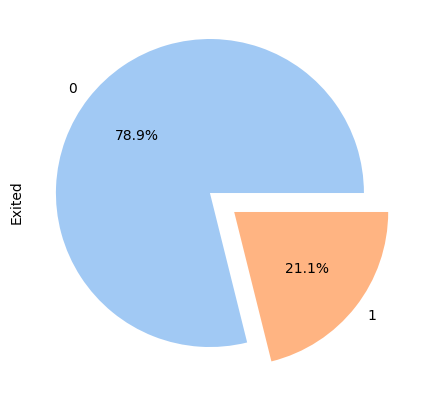

In [9]:
#Target Distribution
plt.figure(figsize=(5,5))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('Exited')['Exited'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

Target is not balanced...

I will try class weight adjusment and oversampling(SMOTE) in modelling part.

## Grouping features for preprocessing purposes

Different data types will require different preprocessing techniques. Here, I will group features for bookkeeping and preprocessing purposes.

In [10]:
train_df.nunique().sort_values()

Gender                 2
HasCrCard              2
IsActiveMember         2
Exited                 2
Geography              3
NumOfProducts          4
Tenure                11
Age                   72
CreditScore          460
Surname             2932
CustomerId         23421
Balance            30239
EstimatedSalary    55581
dtype: int64

In [11]:
# Just bookkeeping
feature_list = [feature for feature in train_df.columns if not feature  == "Exited"]

categorical_features = [feature for feature in train_df.columns if 
                        train_df[feature].dtype == "object"] 
numerical_features = [feature for feature in train_df.columns if 
                      feature not in categorical_features + ['Exited']]

discrete_features = ['HasCrCard', 'IsActiveMember','NumOfProducts']

continuous_features = list(set(numerical_features) - set(discrete_features))

#make sure no little feature left behind
assert feature_list.sort() == (categorical_features + numerical_features).sort()
assert numerical_features.sort() == (continuous_features + discrete_features).sort()


<a id = "4"></a><br>
# Exploratory Data Analysis

Let's observe features with respect to target.

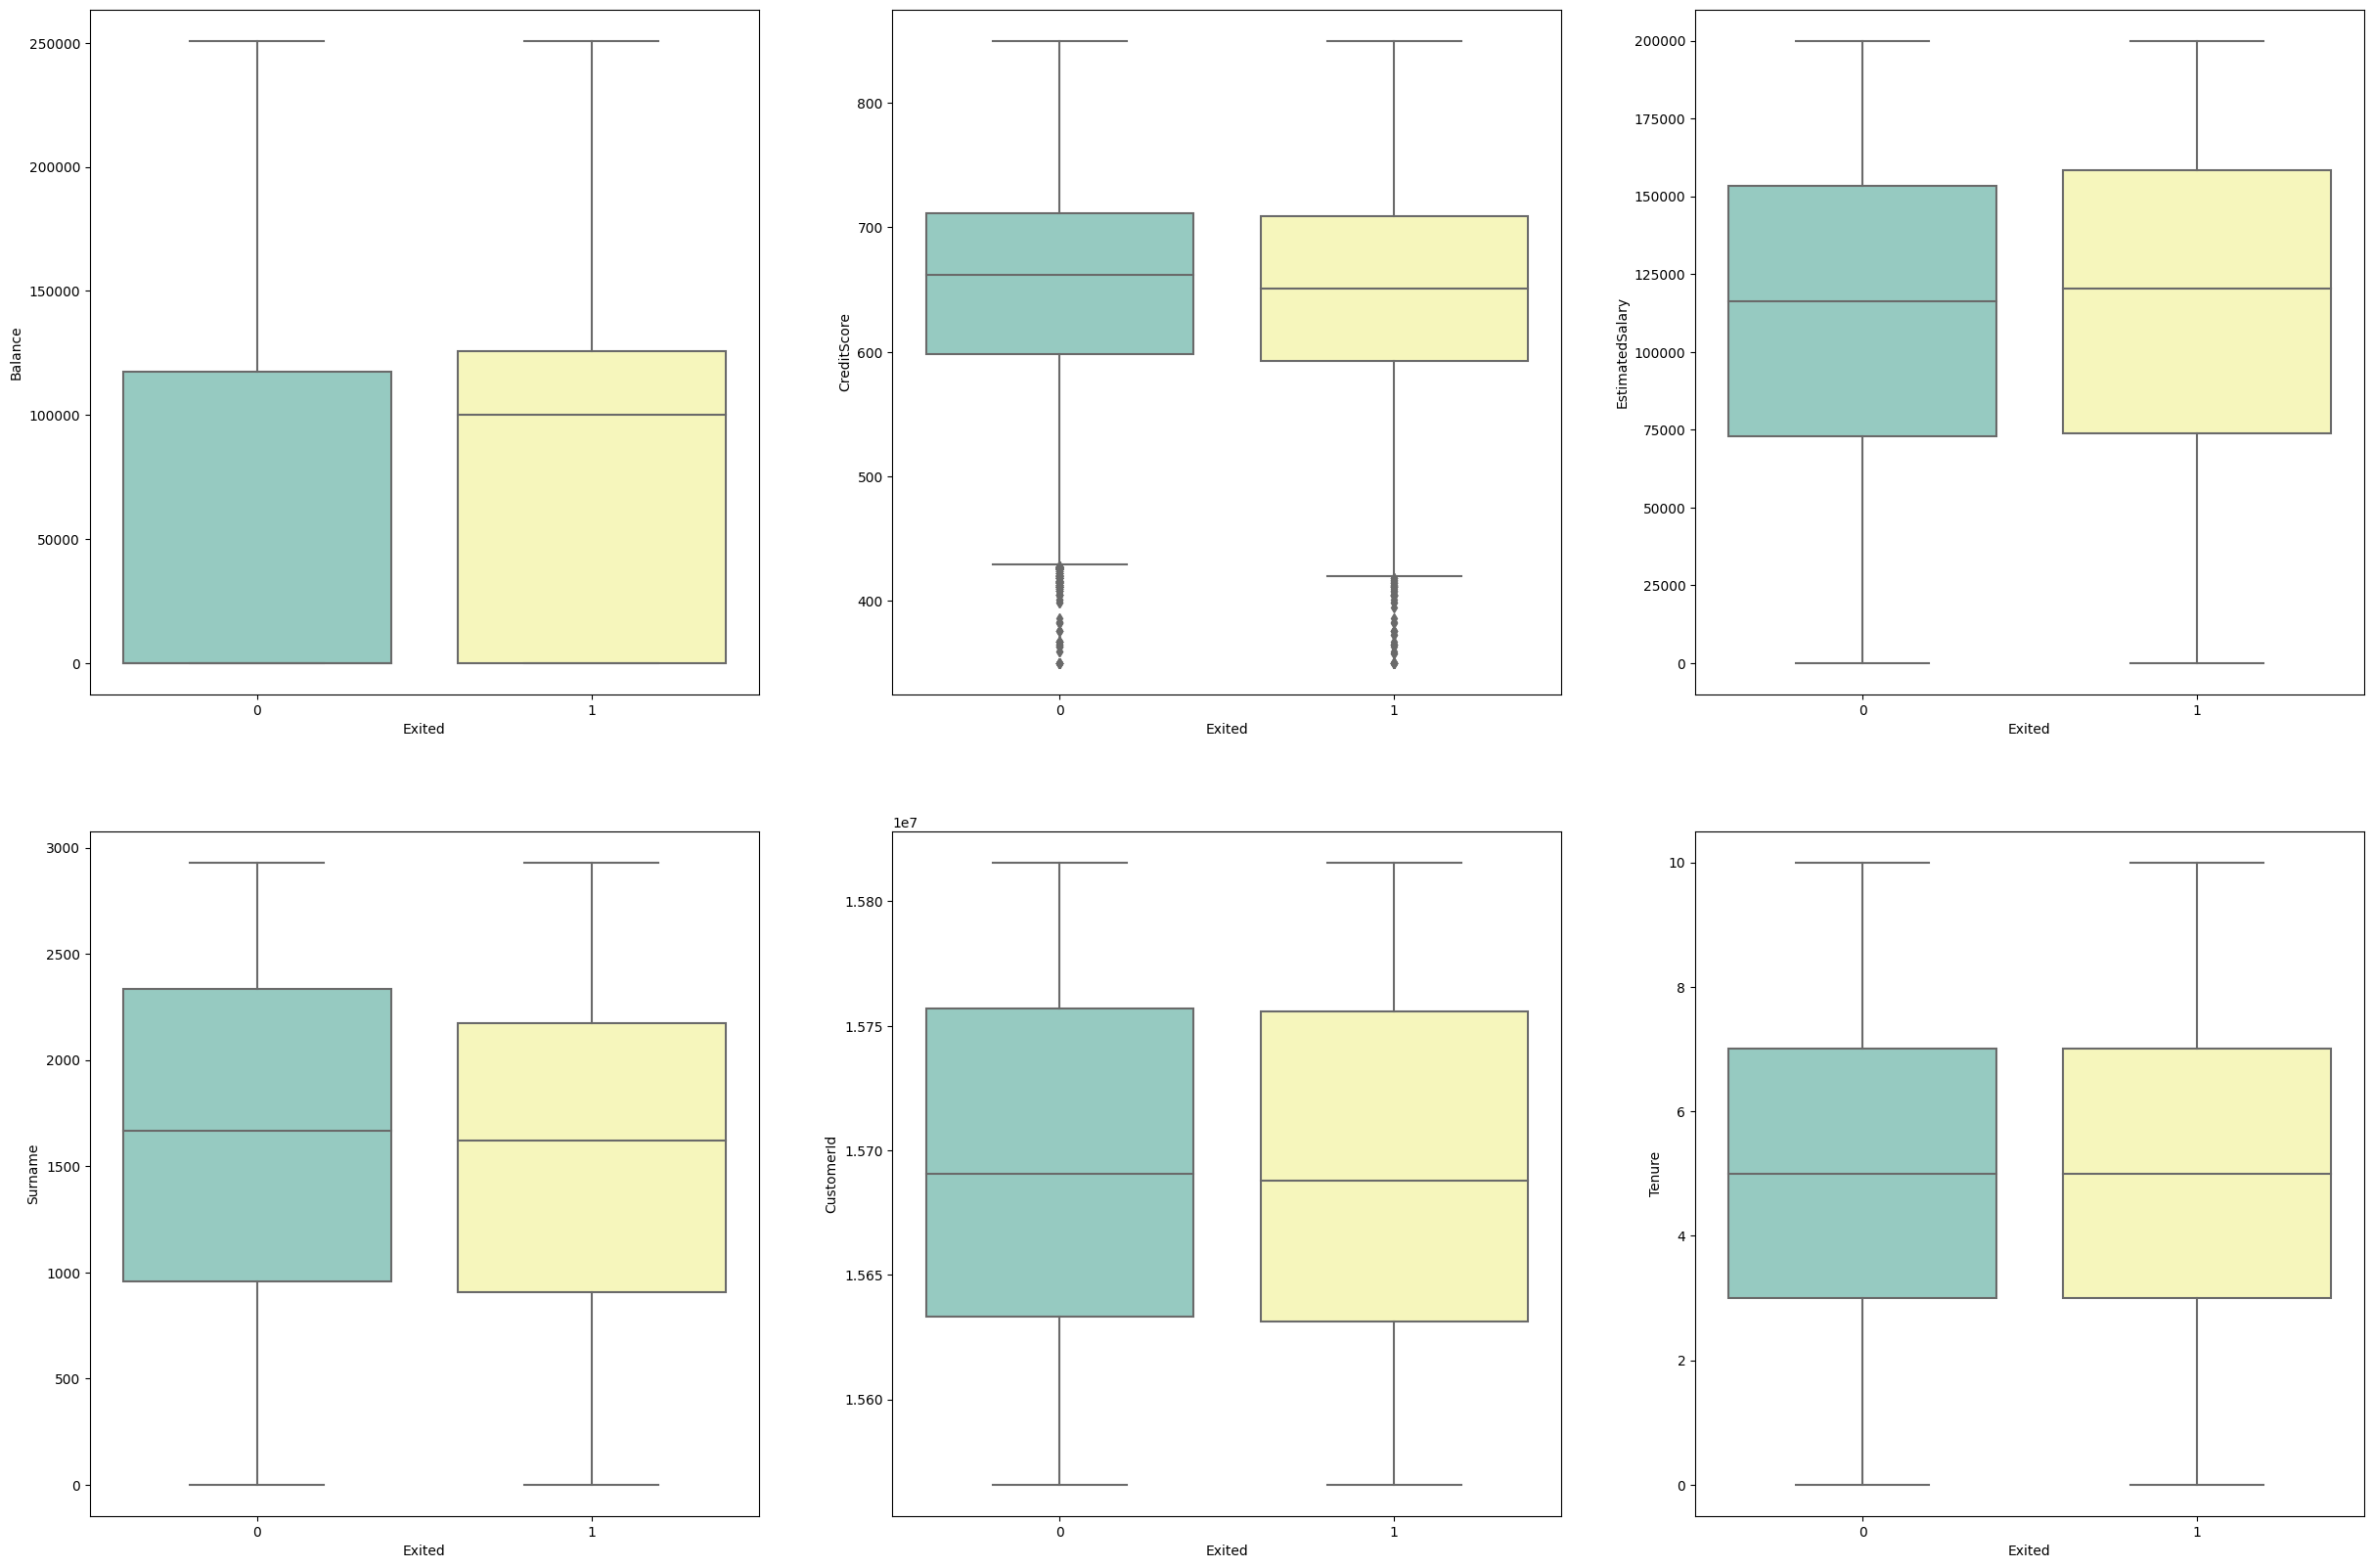

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Exited', y=var, data=train_df, ax=subplot, palette='Set3')

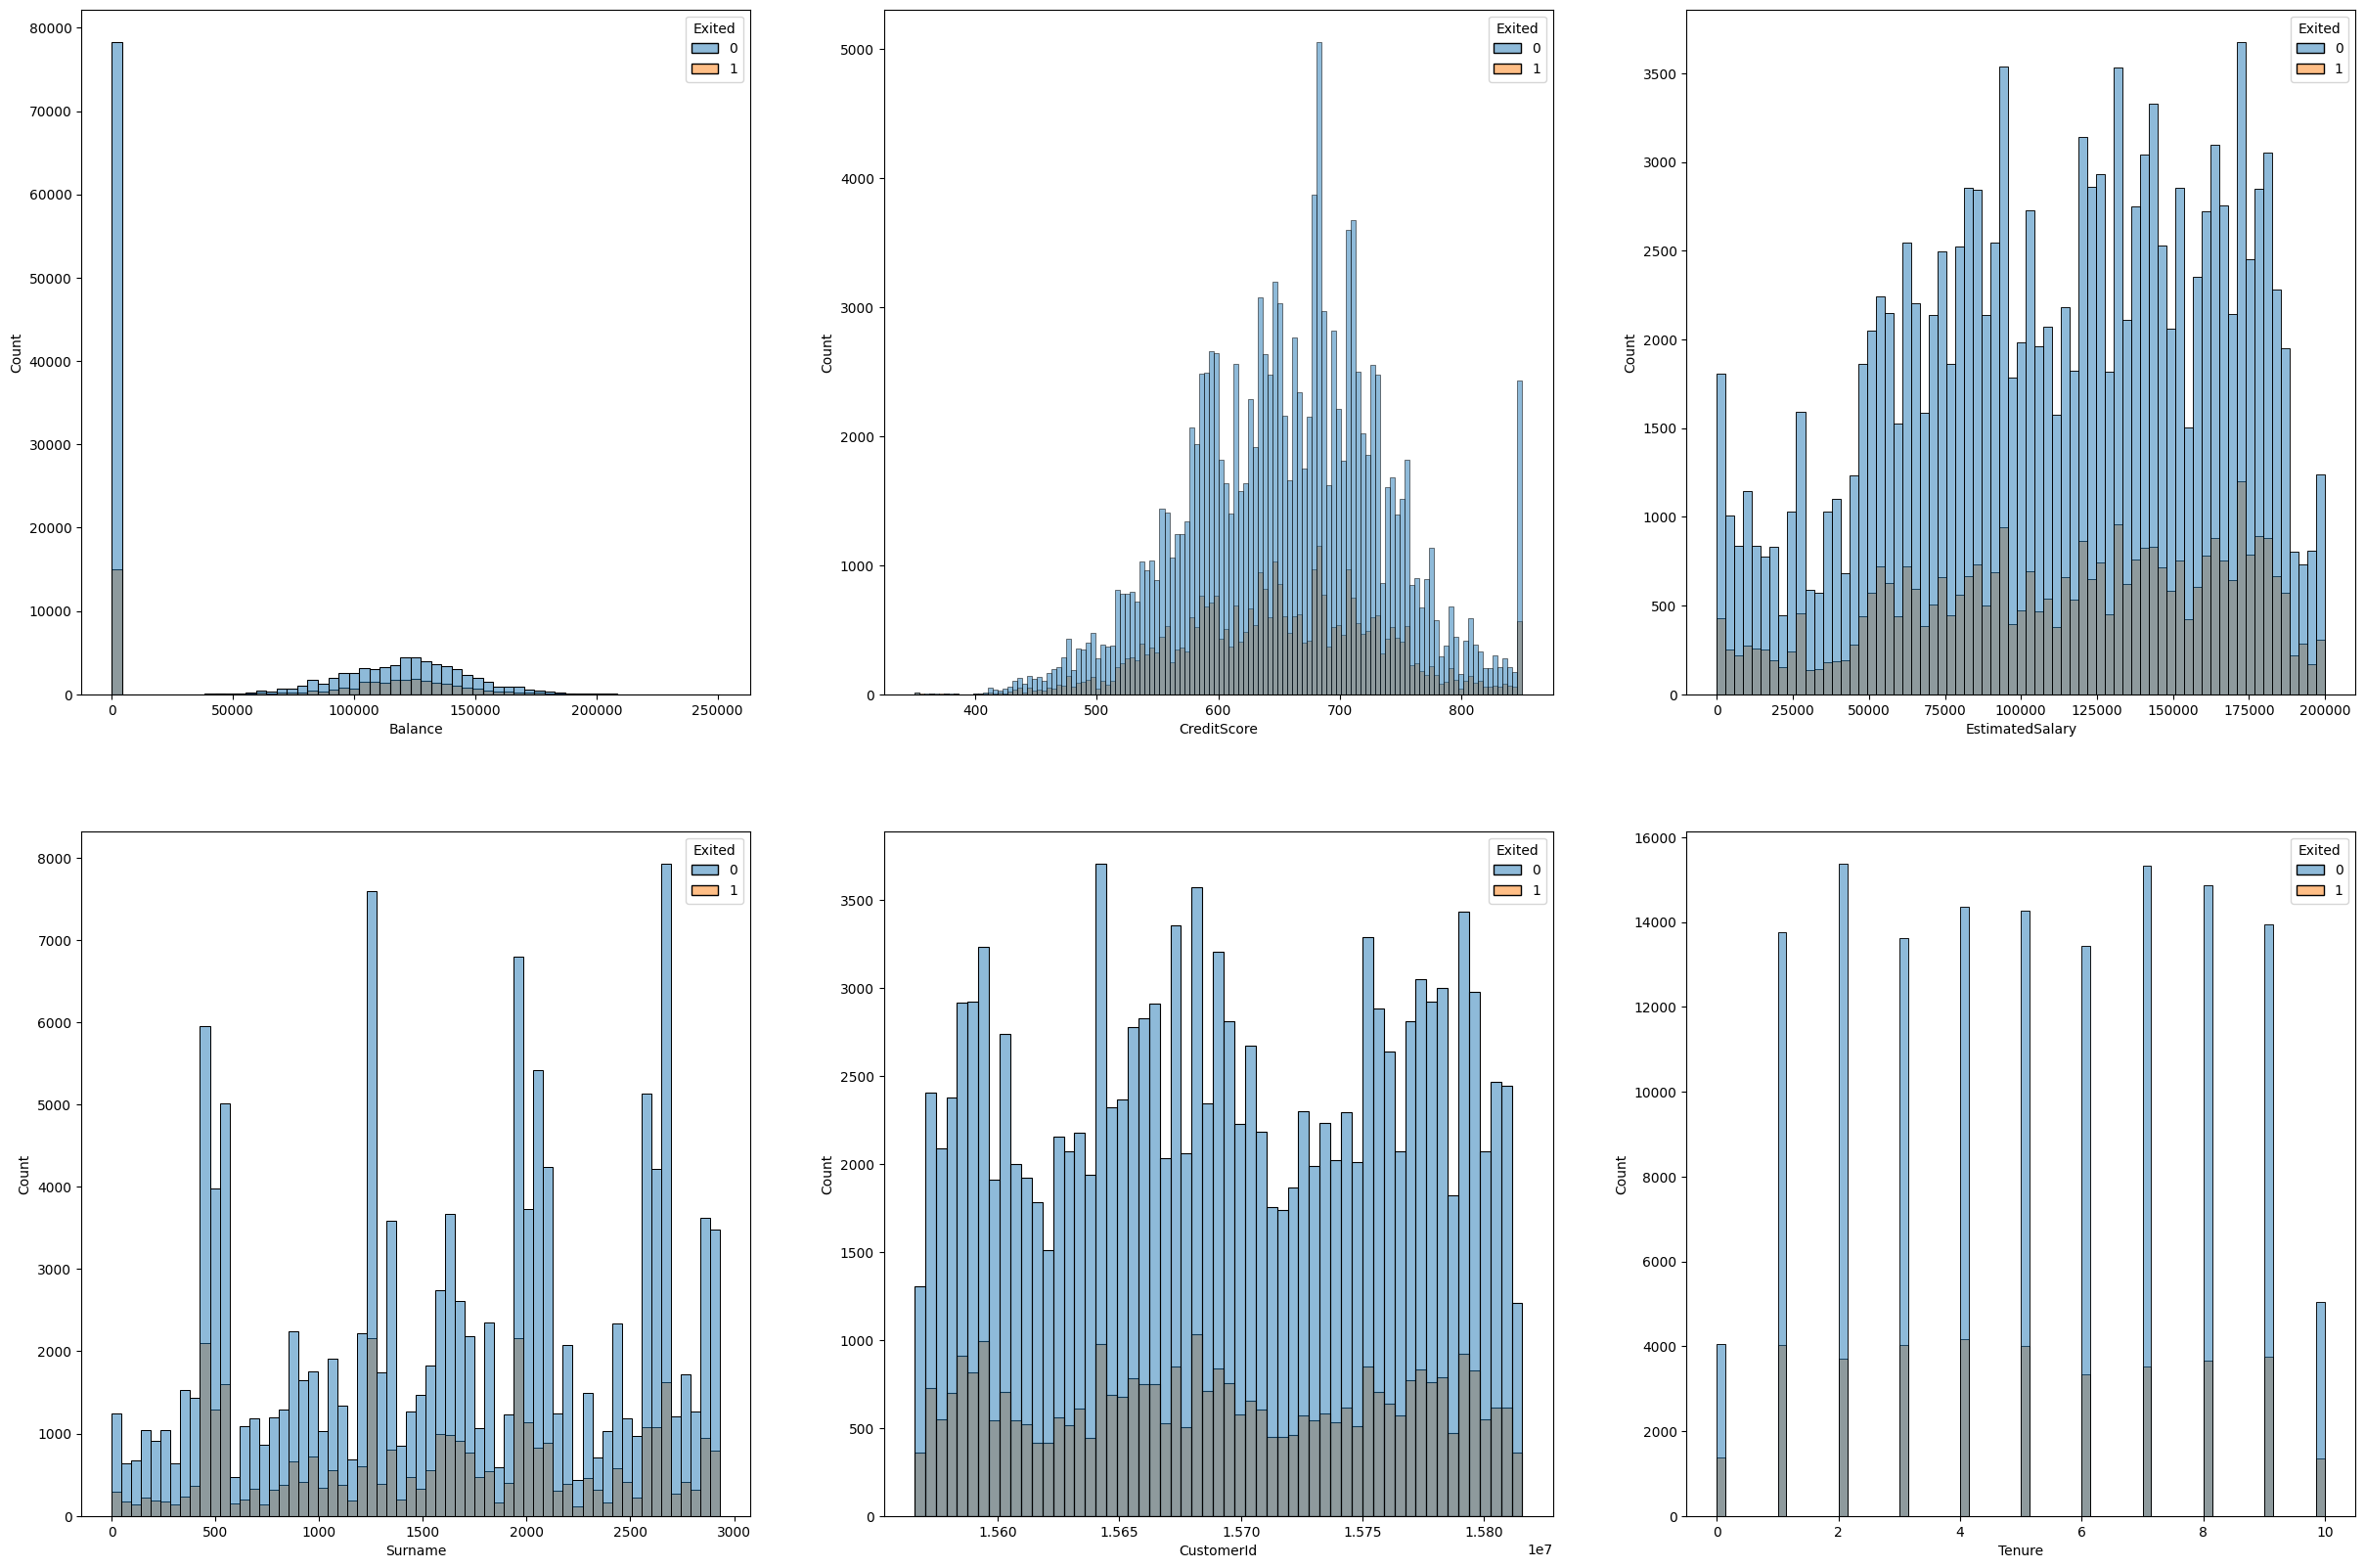

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.histplot(x=var,  data=train_df, ax=subplot, hue='Exited' )

* Younger people are more prone to churn.

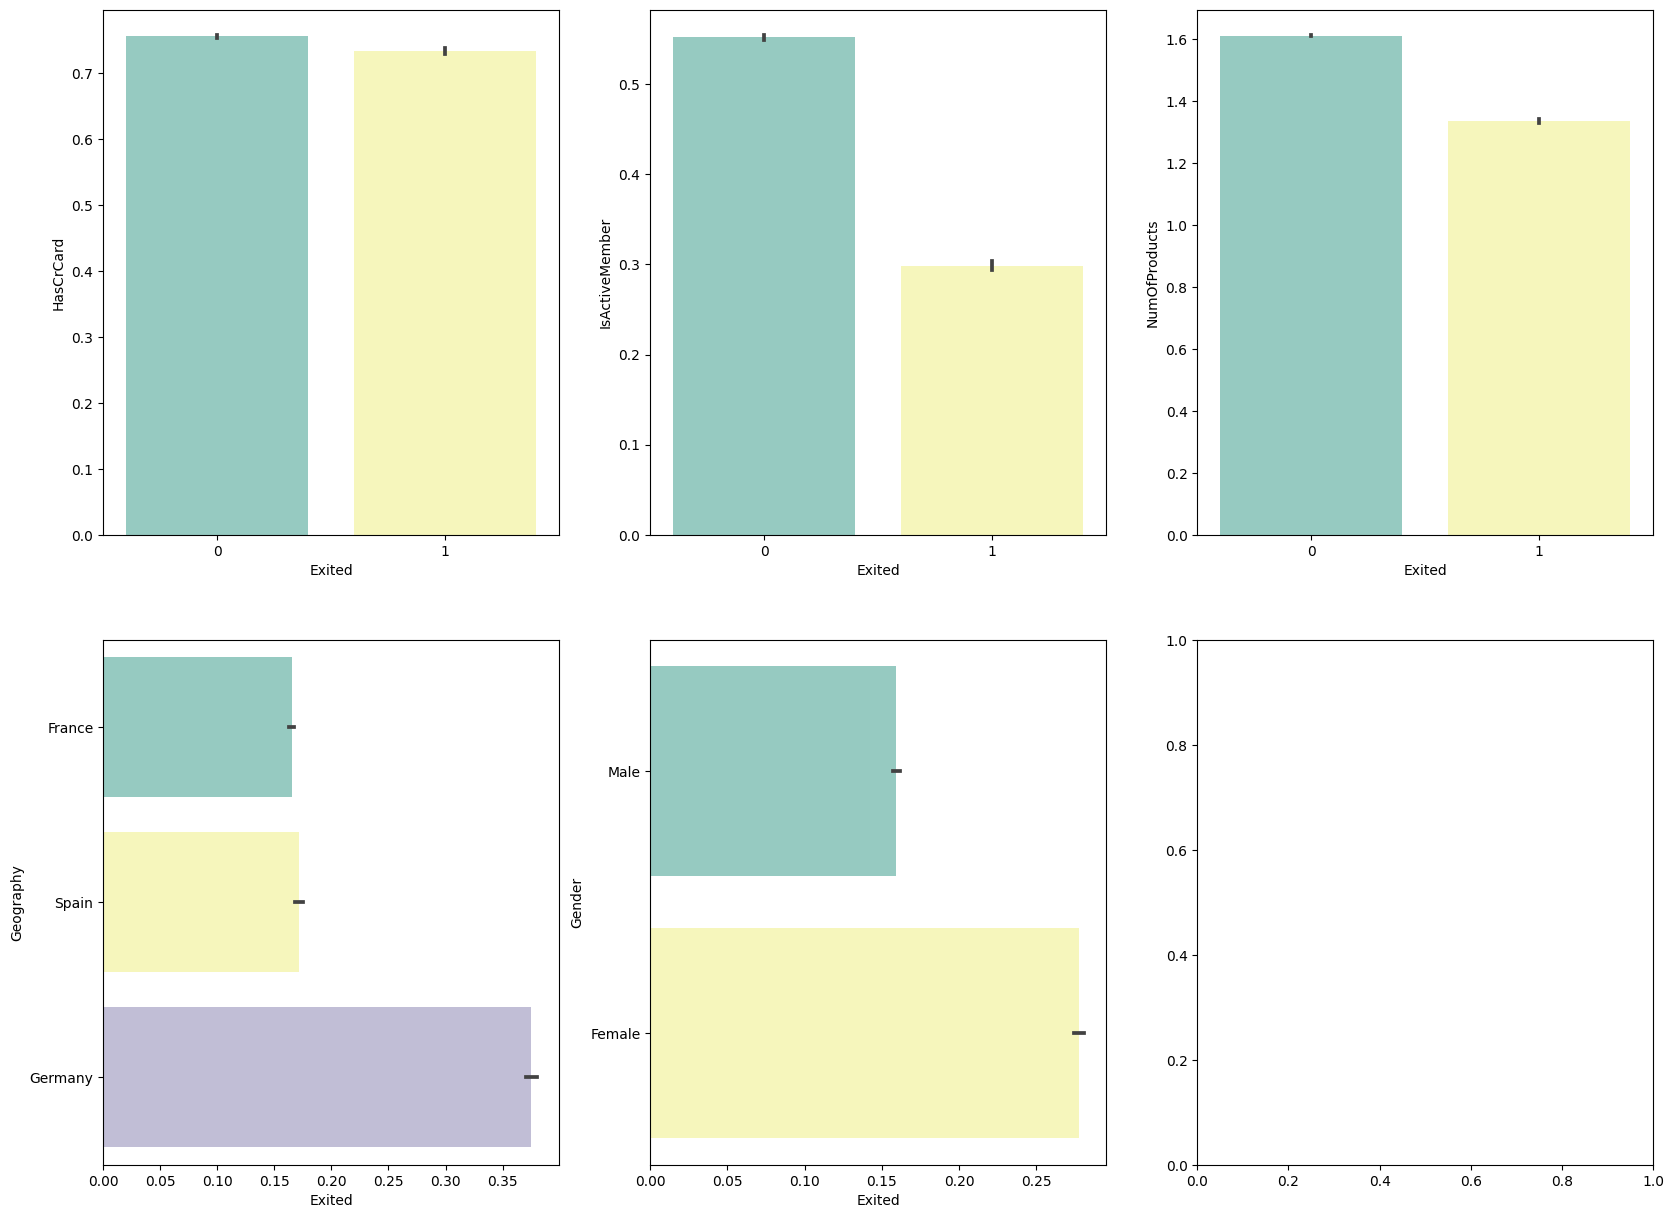

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for var, subplot in zip(discrete_features + categorical_features, ax.flatten()):
    sns.barplot(x='Exited', y= var, data=train_df, ax=subplot, palette='Set3')

* There are more churn in Germany
* Females are more prone to churn
* People with less number of products more prone to churn
* Nonactive members are more prone to churn (What is active member mean? This could mean a data leakage in a real setting)

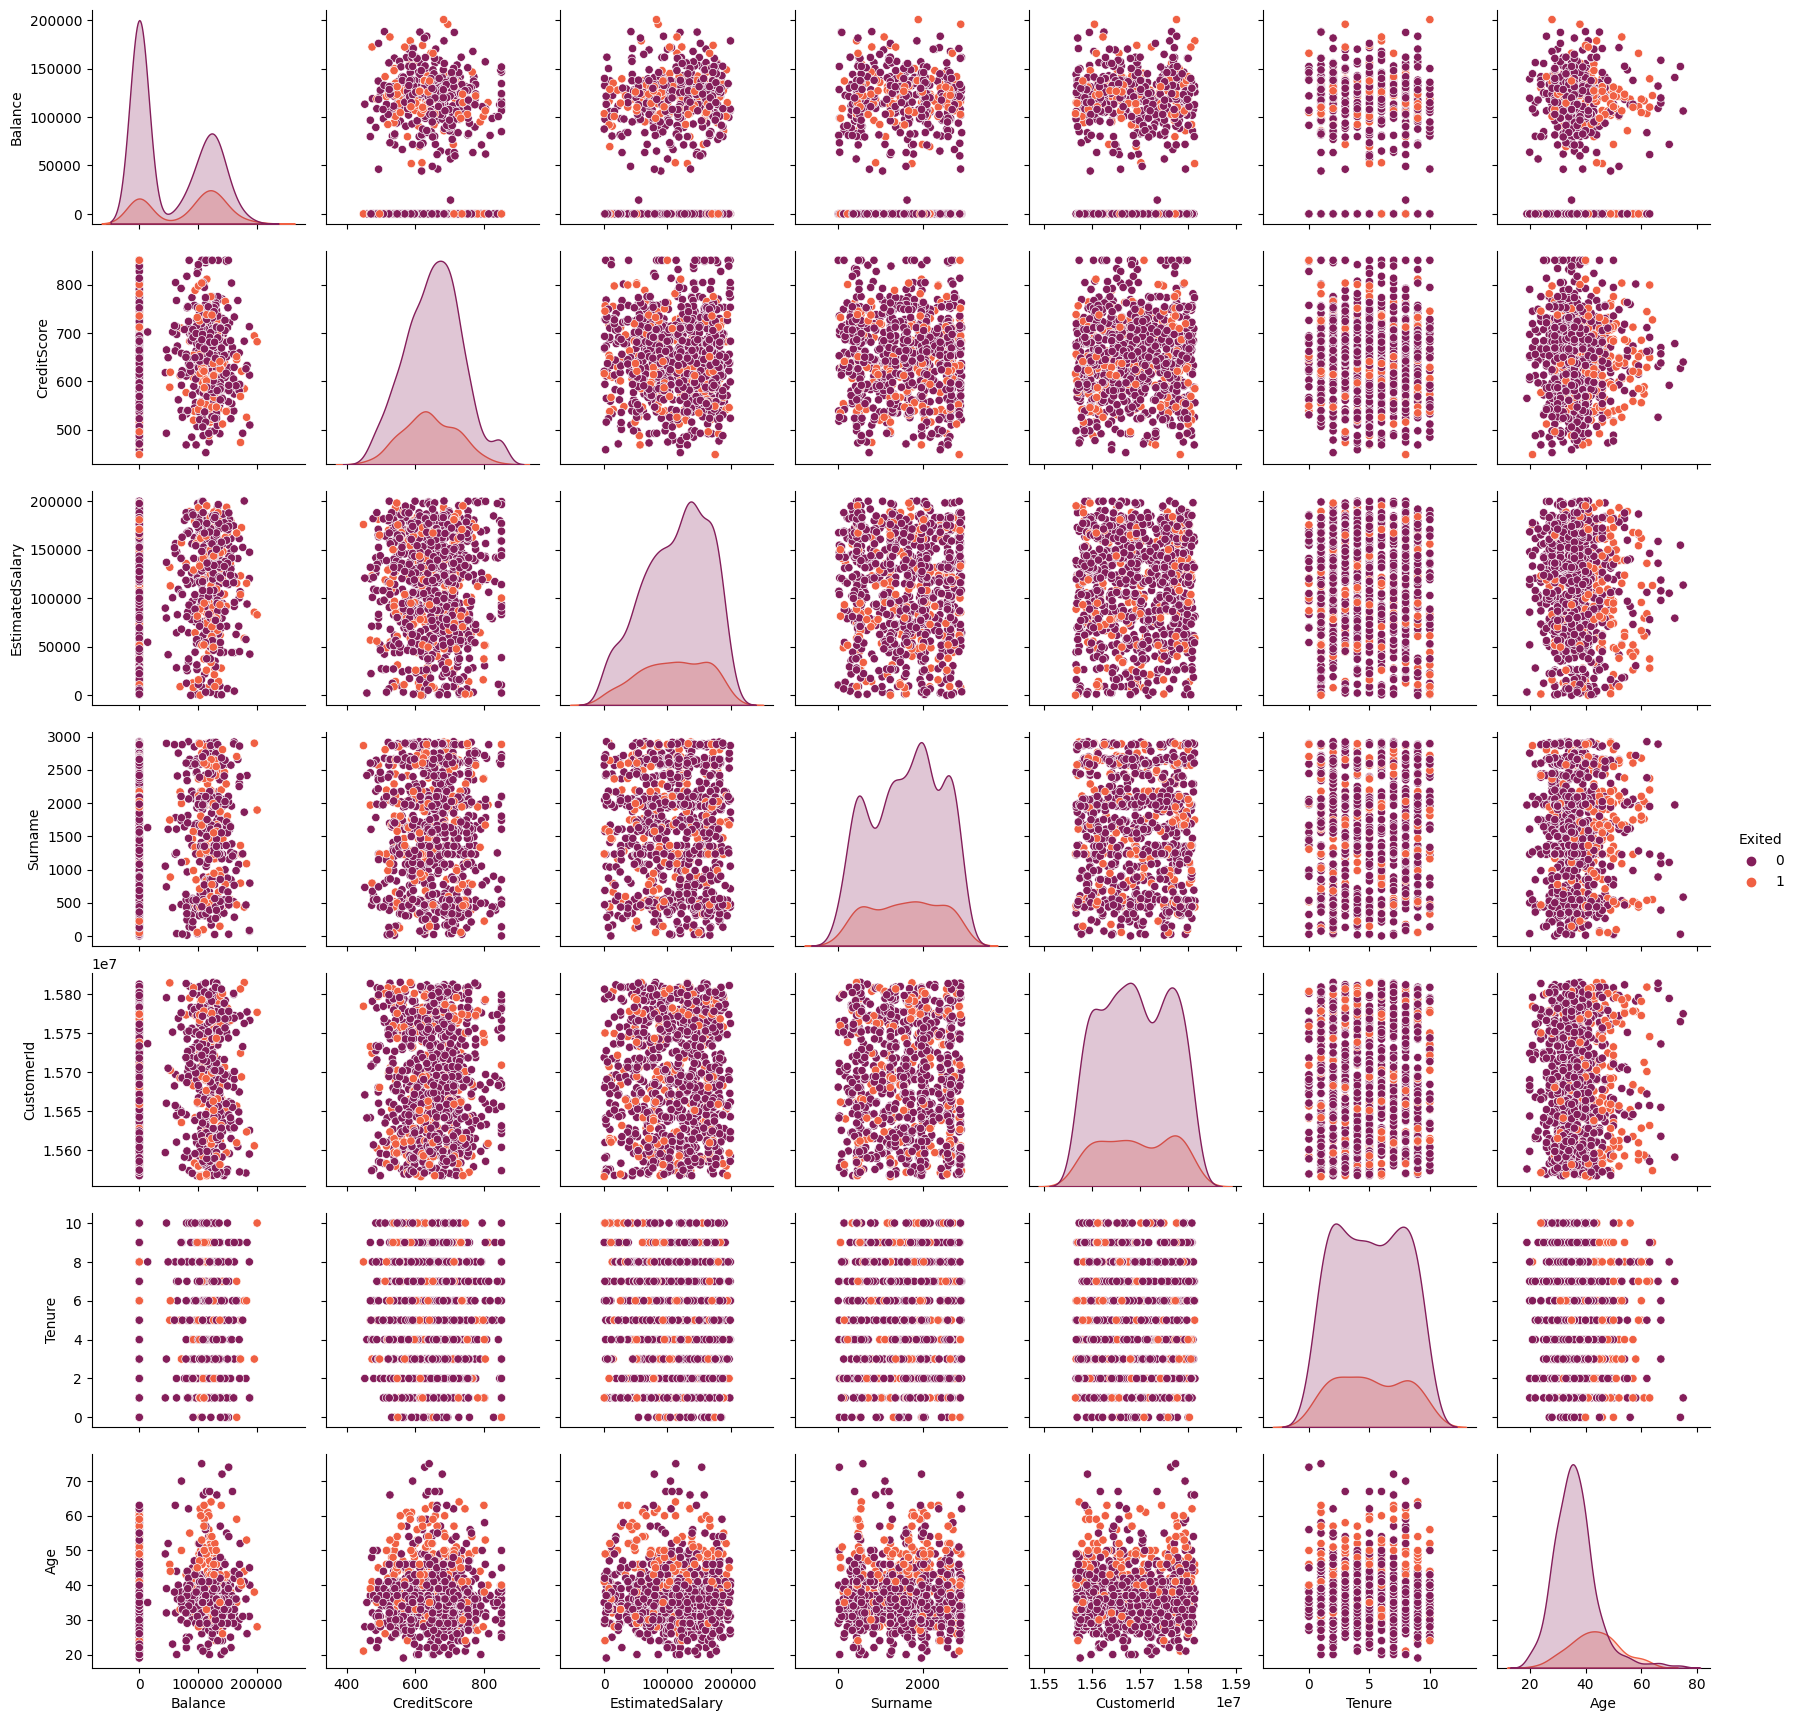

In [15]:
sns.pairplot(train_df[continuous_features + ["Exited"]].sample(n = 1000), hue="Exited", palette='rocket')

* Again age seems like a good predictive feature

Let's look at the relationship between features and the target more quantitatively...

Correlation is not a good measure for classification problems. 

(It is good at measuring linear relations between continuous variables, but our target is discrete)

Let's check mutual information, which measures this kind of relationship well.

In [16]:
y = train_df.Exited

In [17]:
# determine the mutual information for numerical features
#You need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[numerical_features ]

mutual_info = mutual_info_classif(mutual_df, y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


,Numerical_Feature_MI
NumOfProducts,0.097926
Age,0.083821
IsActiveMember,0.043382
HasCrCard,0.025932
Balance,0.016977
Surname,0.014641
EstimatedSalary,0.009927
CreditScore,0.003358
CustomerId,0.003282
Tenure,0.003179


Mutual information also work with preprocessed categorical variables.

In [18]:
mutual_df_categorical = train_df[categorical_features + discrete_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")


,Categorical_Feature_MI
NumOfProducts,0.093231
IsActiveMember,0.037822
Geography,0.022885
Gender,0.019554
HasCrCard,0.001793


We do not have an utterly meaningless feature. I will include all features in the modeling phase.

<a id = "5"></a><br>
# Feature Engineering

To do...

<a id = "6"></a><br>
# Preprocessing

We have good, clean data without missing values. I will use tree-based boosting algorithms so we do not need extensive preprocessing. 
I will only create two objects:

    * Smote for oversampling
    * Encoder for one hot encoding

In [19]:
#SMOTE for oversampling of minority class(class 1)
sm = SMOTE(random_state=random_state)

#for imputing missing values
encoder = OneHotEncoder(handle_unknown = 'ignore')


In [20]:
tree_preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('encoder', encoder, categorical_features),
    ])

tree_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Geography', 'Gender'])])

<a id = "7"></a><br>
# Modeling and hyperparameter tuning

In [21]:
#seperate target
y = train_df['Exited']
train_df = train_df.drop(['Exited'], axis=1)

In [22]:
#create train-test split. 
X_train, X_test, y_train, y_test = train_test_split(train_df, y, 
                                                    test_size=10000,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(165034, 12) (10000, 12)


Tree-based boosting algorithms generally perform well with tabular data sets. I tried LightGBM, XGBoost, HistogramGradientBoosting, and Catboost algorithms. I trained different versions with class weight adjustment, oversampling (SMOTE), and without any extra things concerning unbalanced class distribution.

I used the Optuna package for hyperparameter tuning. 

Here, I will demonstrate cross-validation results with tunned parameters. (This is only for demostration purposes. Cross validation is already applied on Optuna tunning step) 

In the Appendix, you can find Optuna settings for different models. 

<a id = "8"></a><br>
## Base Models

In [23]:
# List all parameters found in hyperparameter tunning process

#lgm simple
lgbm_simple_params ={'n_estimators': 439,
                     'max_depth': 9,
                     'learning_rate': 0.0643282101361018,
                     'min_child_samples': 13,
                     'subsample': 0.38820330877513254,
                     'max_bin': 300,
                     'colsample_bytree': 0.43145735963996845}

#lgm with class weight
lgbm_class_weight_params ={'n_estimators': 498,
                           'max_depth': 6,
                           'learning_rate': 0.047359251329996195,
                           'min_child_samples': 20,
                           'subsample': 0.6377912907721486,
                           'max_bin': 260,
                           'colsample_bytree': 0.5372190078997091,
                           'scale_pos_weight': 0.9483441955116075}

#lgm with smote
lgbm_smote_params ={'n_estimators': 471,
                    'max_depth': 10,
                    'learning_rate': 0.0701731179061537,
                    'min_child_samples': 15,
                    'subsample': 0.20773967005308486,
                    'max_bin': 340,
                    'colsample_bytree': 0.3727961976310182}
#xgb simple
xgb_simple_params  = {'n_estimators': 281,
                      'alpha': 0.024722446617650117,
                      'subsample': 0.9092679197884052,
                      'colsample_bytree': 0.5036745487831261,
                      'max_depth': 6, 
                      'min_child_weight': 3,
                      'learning_rate': 0.07531907957786994,
                      'gamma': 0.00016235463275744927}

#xgb with class weight
xgb_class_weight_params = {'n_estimators': 440,
                           'alpha': 0.0013751461960360158,
                           'subsample': 0.8076590076519942,
                           'colsample_bytree': 0.5573853166048716,
                           'max_depth': 5,
                           'min_child_weight': 2,
                           'learning_rate':  0.0636761270496045,
                           'gamma': 0.0003815606898277253,
                           'scale_pos_weight': 1.2999522592435082}
#xgb with smote
xgb_smote_params = {'n_estimators': 438,
                    'alpha': 0.11760883915536113,
                    'subsample': 0.94327313500221,
                    'colsample_bytree': 0.6605823804562506,
                    'max_depth': 7,
                    'min_child_weight': 3,
                    'learning_rate': 0.04529751888133378,
                    'gamma': 0.013560644038528798}

#histboosting simple
hst_simple_params ={'learning_rate': 0.06641262187295333,
                    'max_iter': 344,
                    'max_depth': 5,
                    'l2_regularization': 0.03411439940430499}

#histboosting with class weight
hst_class_weight_params = {'learning_rate': 0.08893052165501196,
                           'max_iter': 448,
                           'max_depth': 4,
                           'l2_regularization': 0.7792159019097559}

#histboosting with smote
hst_smote_params = {'learning_rate': 0.042008490752076494,
                    'max_iter': 488,
                    'max_depth': 12,
                    'l2_regularization': 0.7715407262993847}

#catboost simple
cat_simple_params = {'iterations': 490,
                     'colsample_bylevel': 0.4110936500315391,
                     'learning_rate':  0.09907817058056112,
                     'random_strength': 0.01727221302379271,
                     'depth': 5,
                     'l2_leaf_reg': 3,
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli',
                     'subsample': 0.6767681550919736}

#catboost with class weight
cat_class_weight_params = {'iterations': 483,
                           'colsample_bylevel': 0.5318555699280899,
                           'learning_rate': 0.10233412103097894,
                           'random_strength': 0.09750092002974313,
                           'depth': 5,
                           'l2_leaf_reg': 4,
                           'boosting_type': 'Plain',
                           'bootstrap_type': 'Bernoulli',
                           'scale_pos_weight': 1.1383812115611798,
                           'subsample': 0.5894531469921895}



#catboost smote
cat_smote_params = {'iterations': 398,
                    'colsample_bylevel': 0.6963459781979415,
                    'learning_rate': 0.10304917629217605,
                    'random_strength': 0.06085528581164544,
                    'depth': 5,
                    'l2_leaf_reg': 3,
                    'boosting_type': 'Plain',
                    'bootstrap_type': 'Bernoulli',
                    'subsample': 0.7140099695149456}

In [24]:
#Construct pipelines

#lgbm pipes
lgbm_simple = LGBMClassifier(**lgbm_simple_params, random_state=random_state, verbose=-1)

pipe_lgbm_simple =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
    #('smote', sm),
    ("lgbm_tunned", lgbm_simple)
])



lgbm_class_weight = LGBMClassifier(**lgbm_class_weight_params, random_state=random_state, verbose=-1)

pipe_lgbm_class_weight =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("lgbm_class_weight", lgbm_class_weight)
])



lgbm_smote = LGBMClassifier(**lgbm_smote_params, random_state=random_state, verbose=-1)

pipe_lgbm_smote =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("lgbm_smote", lgbm_smote)
])



#xgboost pipes
xgb_simple = XGBClassifier(**xgb_simple_params, random_state=random_state)

pipe_xgb_simple =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("xgb_simple", xgb_simple)
])




xgb_class_weight = XGBClassifier(**xgb_class_weight_params, random_state=random_state)

pipe_xgb_class_weight =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("xgb_class_weight", xgb_class_weight)
])



xgb_smote = XGBClassifier(**xgb_smote_params, random_state=random_state)

pipe_xgb_smote =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("xgb_smote", xgb_smote)
])



#hist pipes
hst_simple = HistGradientBoostingClassifier(**hst_simple_params, random_state=random_state)

pipe_hst_simple =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("hst_simple", hst_simple)
])




hst_class_weight = HistGradientBoostingClassifier(**hst_class_weight_params, random_state=random_state, class_weight = 'balanced')

pipe_hst_class_weight =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("hst_class_weight", hst_class_weight)
])


hst_smote = HistGradientBoostingClassifier(**hst_smote_params, random_state=random_state)

pipe_hst_smote =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("hst_smote", hst_smote)
])


#cat boost pipes
cat_simple = CatBoostClassifier(**cat_simple_params, random_state =random_state, logging_level='Silent')

pipe_cat_simple =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("cat_simple", cat_simple)
])




cat_class_weight = CatBoostClassifier(**cat_class_weight_params, random_state =random_state, logging_level='Silent')

pipe_cat_class_weight =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("cat_class_weight", cat_class_weight)
])


cat_smote = CatBoostClassifier(**cat_smote_params, random_state =random_state, logging_level='Silent')

pipe_cat_smote =imbpipeline([
    
    ('tree_preprocessor', tree_preprocessor),
    ('smote', sm),
    ("cat_smote", cat_smote)
])

<a id = "9"></a><br>
## Ensemble with simple voting

In [25]:
estimators = [
    
    ('pipe_lgbm_simple', pipe_lgbm_simple),
    ('pipe_lgbm_class_weight', pipe_lgbm_class_weight),
    ('pipe_lgbm_smote', pipe_lgbm_smote),
    ('pipe_xgb_simple', pipe_xgb_simple),
    ('pipe_xgb_class_weight', pipe_xgb_class_weight),
    ("pipe_xgb_smote", pipe_xgb_smote),
    #("pipe_hst_simple", pipe_hst_simple),
    #("pipe_hst_smote", pipe_hst_smote),
    #("pipe_hst_class_weight", pipe_hst_class_weight),
    #("pipe_cat_simple", pipe_cat_simple),
    #("pipe_cat_class_weight", pipe_cat_class_weight),
    #("pipe_cat_smote", pipe_cat_smote)

]

In [26]:
Voting_ensemble = VotingClassifier(estimators=estimators, voting = 'soft')
Voting_ensemble

VotingClassifier(estimators=[('pipe_lgbm_simple',
                              Pipeline(steps=[('tree_preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('encoder',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['Geography',
                                                                                 'Gender'])])),
                                              ('lgbm_tunned',
                                               LGBMClassifier(colsample_bytree=0.43145735963996845,
                                                              learning_rate=0.0643282101361018,
                                                              max_bin=300,
                                                              max_depth=9,
                                                              min_chi...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.04529751888133378,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=7,
                                                             max_leaves=None,
                                                             min_child_weight=3,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=438,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))]))],
                 voting='soft')

Vating classifier makes final decision based on average probability estimates of base models.

<a id = "10"></a><br>
# Ensemble with Stacking

In [27]:
stacking_ensemble = StackingClassifier(estimators=estimators, final_estimator = LogisticRegression(random_state=random_state, C = 0.00001))
stacking_ensemble

StackingClassifier(estimators=[('pipe_lgbm_simple',
                                Pipeline(steps=[('tree_preprocessor',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('encoder',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['Geography',
                                                                                   'Gender'])])),
                                                ('lgbm_tunned',
                                                 LGBMClassifier(colsample_bytree=0.43145735963996845,
                                                                learning_rate=0.0643282101361018,
                                                                max_bin=300,
                                                                max_depth=9,
                                                                min_c...
                                                               interaction_constraints=None,
                                                               learning_rate=0.04529751888133378,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=3,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=438,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))]))],
                   final_estimator=LogisticRegression(C=1e-05, random_state=42))

Stacking just takes out-of-fold predictions from base learners (classifiers in our case) and feed it to a meta-learner to make a final prediction.

![ ]( https://miro.medium.com/max/1400/1*XsTcX5N6FXQW1bGhS9hxJQ.png )
reference- https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b

The following code demonstrates how a stacking model can be cross-validated with grid search. This is how I got C = 0.00001 in the final estimator logistic regression.

You can comment out and try it. But be aware that it's quite computationally intensive. (It takes about two and a half hours)

In [28]:
#%%time

#models

#estimators = [pipe_lgbm_simple,
#              pipe_lgbm_class_weight,
#              pipe_lgbm_smote,
#              pipe_xgb_simple,
#              pipe_xgb_class_weight,
#              pipe_xgb_smote,
#              pipe_hst_simple,
#              pipe_hst_smote,
#              pipe_hst_class_weight,
#              pipe_cat_simple,
#              pipe_cat_class_weight,
#              pipe_cat_smote
              
              
#]

#meta model
#lr = LogisticRegression(random_state=random_state)

#meta model params
#params = { 'meta_classifier__C': [0.00001, 0.001, 0.01, 1.0, 10.0 ]}

#Cross validation strategy
#ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)


#sclf = StackingCVClassifier(classifiers=estimators,
#                            meta_classifier=lr,
#                            use_probas=True,
#                            random_state=random_state)


#grid = GridSearchCV(estimator=sclf, 
#                    param_grid=params, 
#                    cv=ss,
#                    scoring = 'roc_auc',
#                    refit=True)


#grid.fit(X_train, y_train)

#cv_keys = ('mean_test_score', 'std_test_score', 'params')

#for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#    print("%0.6f +/- %0.6f %r"
#          % (grid.cv_results_[cv_keys[0]][r],
#             grid.cv_results_[cv_keys[1]][r],
#             grid.cv_results_[cv_keys[2]][r]))

#print('Best parameters: %s' % grid.best_params_)
#print('AUC: %.6f' % grid.best_score_)

I also added a few more methods for ensembling in the appendix. 
They are faster, but they use test set for optimization, making them more prone to overfitting.


<a id = "11"></a><br>
# Model Validation

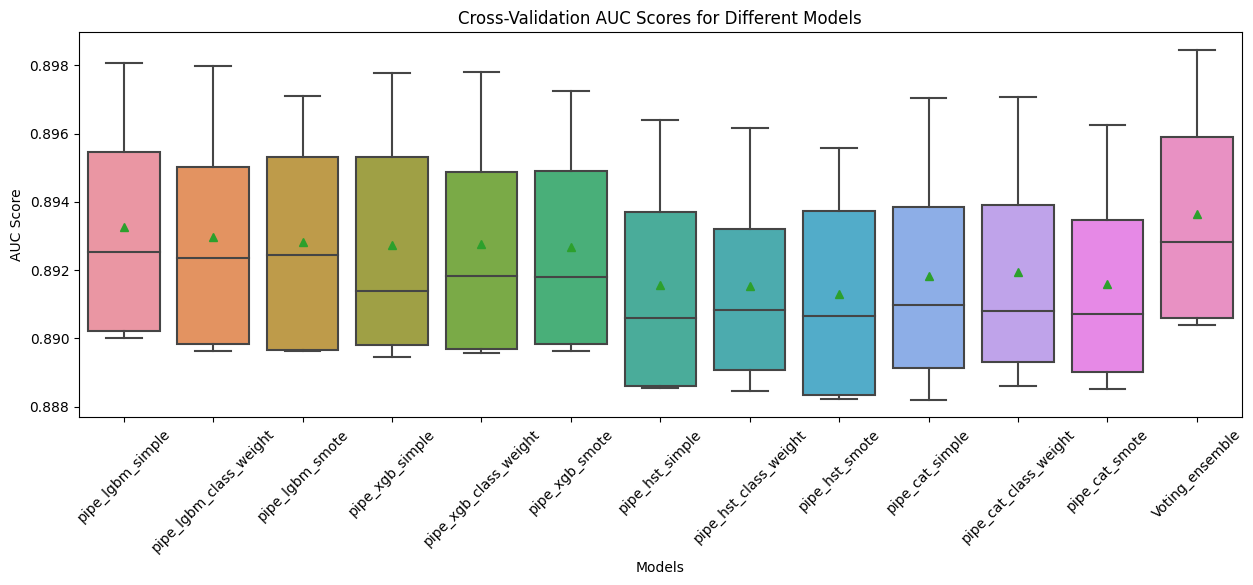

CPU times: user 26min 24s, sys: 1min 26s, total: 27min 51s
Wall time: 16min 8s


In [29]:
%%time
models = {
    'pipe_lgbm_simple': pipe_lgbm_simple,
    'pipe_lgbm_class_weight': pipe_lgbm_class_weight,
    'pipe_lgbm_smote': pipe_lgbm_smote,
    'pipe_xgb_simple': pipe_xgb_simple,
    'pipe_xgb_class_weight': pipe_xgb_class_weight,
    "pipe_xgb_smote": pipe_xgb_smote,
    "pipe_hst_simple": pipe_hst_simple,
    "pipe_hst_class_weight": pipe_hst_class_weight,
    "pipe_hst_smote": pipe_hst_smote,
    "pipe_cat_simple": pipe_cat_simple,
    "pipe_cat_class_weight": pipe_cat_class_weight,
    "pipe_cat_smote": pipe_cat_smote,
    "Voting_ensemble": Voting_ensemble,
    #"stacking_ensemble": stacking_ensemble Voting ensemble perform little bir better. (Running a cv on stacking tekes quite time  so I exluded here)

}

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
# Cross-validation and collect AUC scores
auc_scores = {}
for model_name, model in models.items():
    auc_scores[model_name] = cross_val_score(model, X_train, y_train, cv=ss, scoring='roc_auc')

# Create a boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(data=list(auc_scores.values()), showmeans=True)
plt.xticks(ticks=np.arange(len(models)), labels=list(models.keys()))
plt.xticks(rotation=45)
plt.title('Cross-Validation AUC Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.show()

In [30]:
df_results_df = pd.DataFrame.from_dict(auc_scores,orient = 'index', columns=['fold-1','fold2','fold3','fold4','fold5'])
df_results_df['Mean'] = df_results_df.mean(axis=1)
df_results_df['Std'] = df_results_df.std(axis=1)
df_results_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Reds')

,fold-1,fold2,fold3,fold4,fold5,Mean,Std
Voting_ensemble,0.895888,0.890385,0.890608,0.898460,0.892836,0.893635,0.003122
pipe_lgbm_simple,0.895466,0.890022,0.890227,0.898072,0.892528,0.893263,0.003106
pipe_lgbm_class_weight,0.895023,0.889619,0.889843,0.897980,0.892357,0.892964,0.003184
pipe_lgbm_smote,0.895308,0.889620,0.889643,0.897118,0.892441,0.892826,0.003005
pipe_xgb_class_weight,0.894870,0.889562,0.889676,0.897822,0.891838,0.892754,0.003183
pipe_xgb_simple,0.895307,0.889459,0.889793,0.897781,0.891386,0.892745,0.003264
pipe_xgb_smote,0.894906,0.889641,0.889843,0.897260,0.891802,0.892690,0.002966
pipe_cat_class_weight,0.893916,0.888587,0.889305,0.897087,0.890799,0.891939,0.003159
pipe_cat_simple,0.893848,0.888197,0.889123,0.897047,0.890965,0.891836,0.003242
pipe_cat_smote,0.893458,0.888525,0.889008,0.896249,0.890714,0.891591,0.002899


Voting ensemble has higher AUC score at cross validation.

<a id = "12"></a><br>
# Model Evaluation 

Let's also compare performances on test set.

In [31]:
%%time
models = []

models.append(("pipe_lgbm_simple", pipe_lgbm_simple))
models.append(("pipe_lgbm_class_weight", pipe_lgbm_class_weight))
models.append(("pipe_lgbm_smote", pipe_lgbm_smote))
models.append(("pipe_xgb_simple", pipe_xgb_simple))
models.append(("pipe_xgb_class_weight", pipe_xgb_class_weight))
models.append(("pipe_xgb_smote", pipe_xgb_smote))
models.append(("pipe_hst_simple", pipe_hst_simple))
models.append(("pipe_hst_class_weight", pipe_hst_class_weight))
models.append(("pipe_hst_smote", pipe_hst_smote))
models.append(("pipe_cat_simple", pipe_cat_simple))
models.append(("pipe_cat_class_weight", pipe_cat_class_weight))
models.append(("pipe_cat_smote", pipe_cat_smote))
models.append(("Voting_ensemble", Voting_ensemble))
#models.append(("stacking_ensemble", stacking_ensemble))


accT = []

for name, model in models:
    
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        accT.append([name, roc_auc_score(y_test, y_pred)])
        
results = pd.DataFrame(accT, columns = ['model', 'AUC']).sort_values(by = 'AUC', ascending = False)

results.style.background_gradient('Reds')

CPU times: user 6min 14s, sys: 17.7 s, total: 6min 31s
Wall time: 3min 46s


,model,AUC
12,Voting_ensemble,0.889711
4,pipe_xgb_class_weight,0.889642
2,pipe_lgbm_smote,0.889619
3,pipe_xgb_simple,0.889397
0,pipe_lgbm_simple,0.888961
5,pipe_xgb_smote,0.888550
1,pipe_lgbm_class_weight,0.888189
9,pipe_cat_simple,0.888027
8,pipe_hst_smote,0.887526
10,pipe_cat_class_weight,0.887352


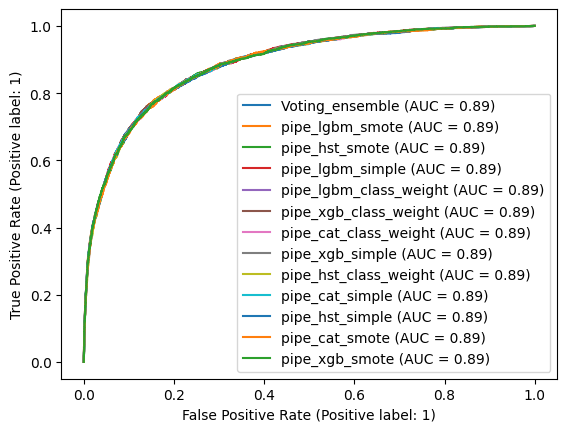

In [32]:
disp = RocCurveDisplay.from_estimator(Voting_ensemble, X_test, y_test, name= 'Voting_ensemble')
RocCurveDisplay.from_estimator(pipe_lgbm_smote, X_test, y_test, name= 'pipe_lgbm_smote', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_hst_smote, X_test, y_test, name= 'pipe_hst_smote', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_lgbm_simple, X_test, y_test, name= 'pipe_lgbm_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_lgbm_class_weight, X_test, y_test, name= 'pipe_lgbm_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_xgb_class_weight, X_test, y_test, name= 'pipe_xgb_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_cat_class_weight, X_test, y_test,  name= 'pipe_cat_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_xgb_simple, X_test, y_test,  name= 'pipe_xgb_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_hst_class_weight, X_test, y_test,  name= 'pipe_hst_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_cat_simple, X_test, y_test,  name= 'pipe_cat_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_hst_simple, X_test, y_test,  name= 'pipe_hst_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_cat_smote, X_test, y_test,  name= 'pipe_cat_smote', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_xgb_smote, X_test, y_test,  name= 'pipe_xgb_smote', ax=disp.ax_);

Voting ensemble also has best AUC score on test set.

Let's plot ConfusionMatrix and ClassificationReport for voting ensemble

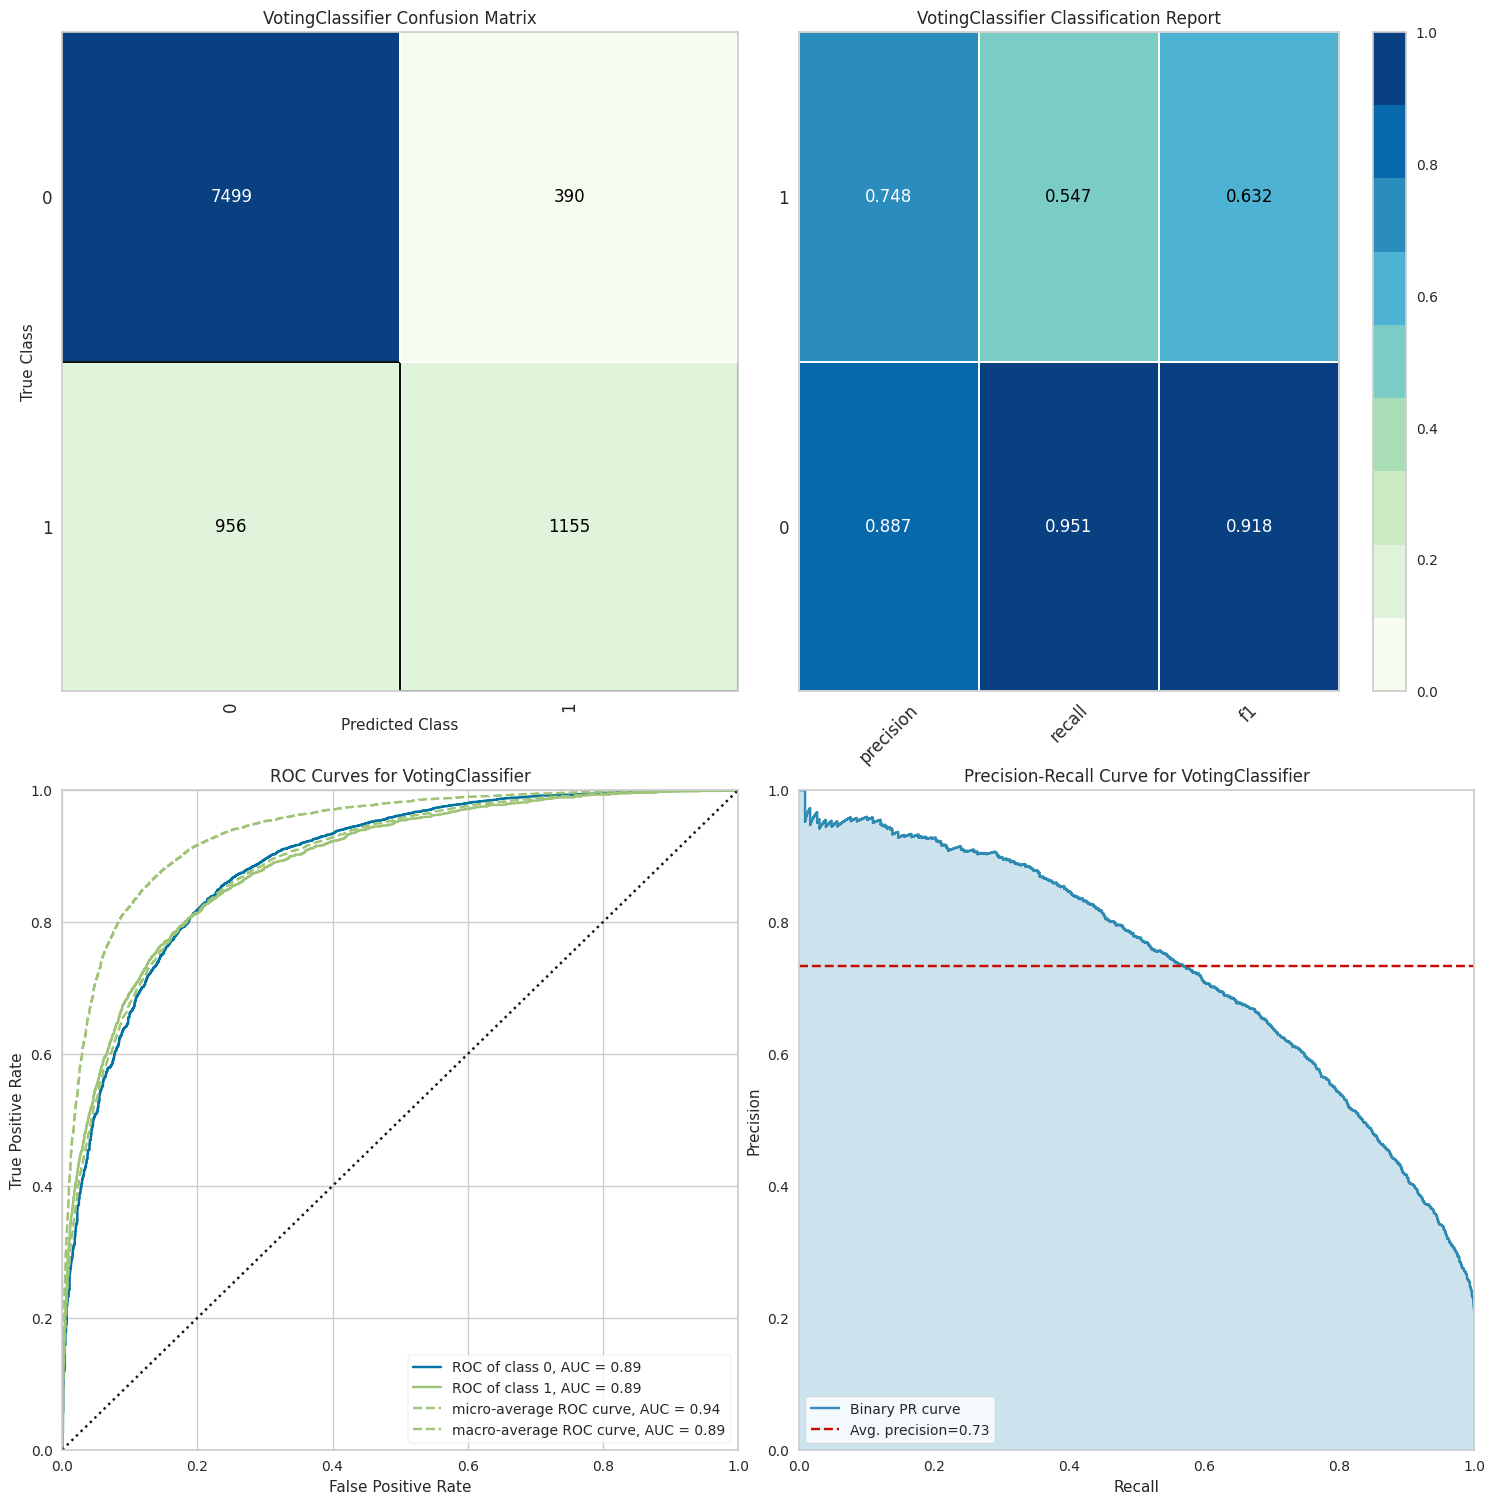

In [33]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, PrecisionRecallCurve

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

model = Voting_ensemble
visualgrid = [

    ConfusionMatrix(model, ax=axes[0][0], cmap= 'GnBu'),
    ClassificationReport(model, ax=axes[0][1], cmap= 'GnBu'),
    ROCAUC(model, ax=axes[1][0]),
    PrecisionRecallCurve(model, ax=axes[1][1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()

<a id = "13"></a><br>
# Explainable ML & Feature importances

Model ensembling generally works better in terms of metrics. However, as models get complicated, they become less explainable. But most of the time, we do not only seek a more accurate model. We also need insights. Feature importance plots are great for this purpose. 

Pipeline usage creates some problems with yellowbrick and shap. Let's simplify things...

In [34]:
X_train_explain =tree_preprocessor.fit_transform(X_train)
X_train_explain = pd.DataFrame(X_train_explain, columns=tree_preprocessor.get_feature_names_out())

X_test_explain = tree_preprocessor.transform(X_test)
X_test_explain = pd.DataFrame(X_test_explain, columns=tree_preprocessor.get_feature_names_out())


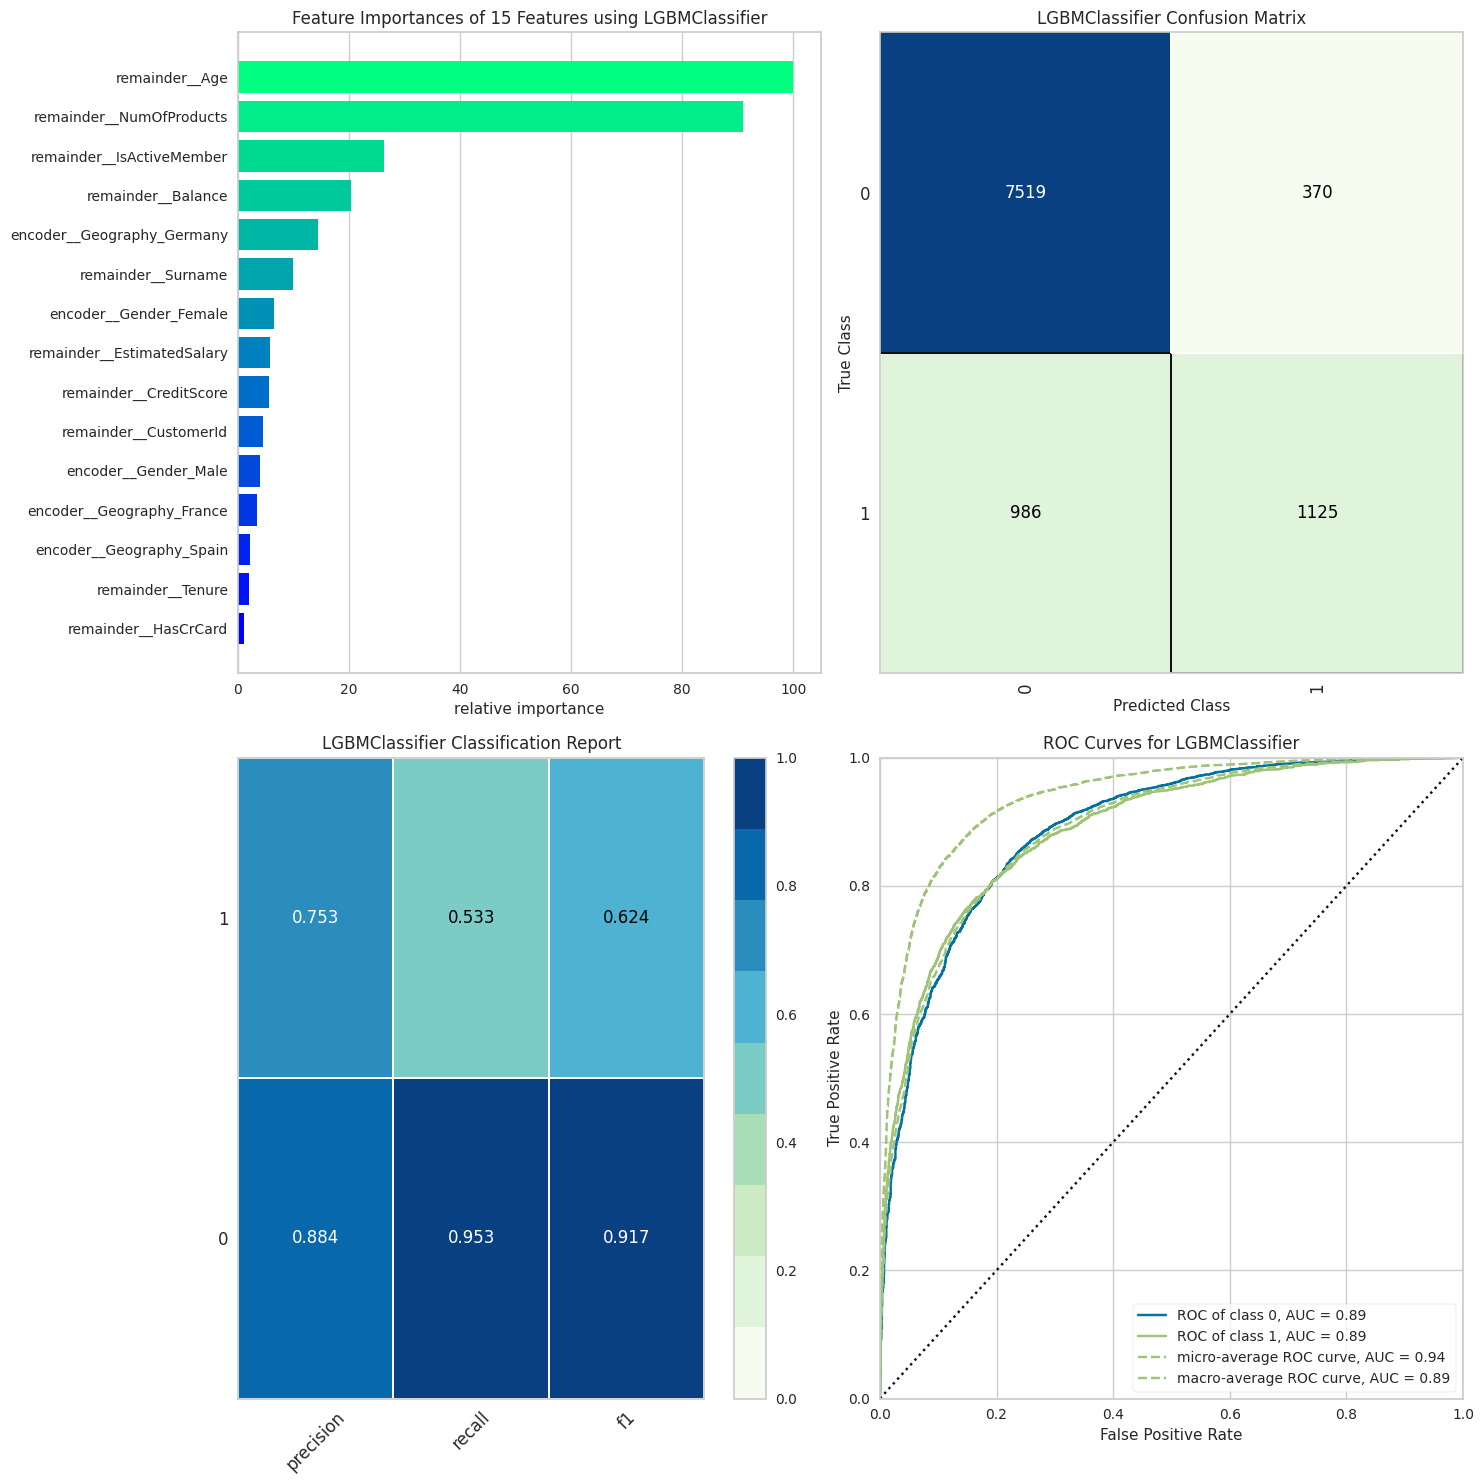

In [35]:
#plot feature importance and summarize best performing model performance
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, DiscriminationThreshold

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

model = lgbm_simple
model.importance_type = 'gain'


visualgrid = [
    FeatureImportances(model,  ax=axes[0][0], colormap= 'winter'),
    ConfusionMatrix(model, ax=axes[0][1], cmap= 'GnBu'),
    ClassificationReport(model, ax=axes[1][0], cmap= 'GnBu'),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train_explain, y_train)
    viz.score(X_test_explain, y_test)
    viz.finalize()

plt.show()

Shap is another tool for explainability. 

100%|===================| 9967/10000 [02:34<00:00]       

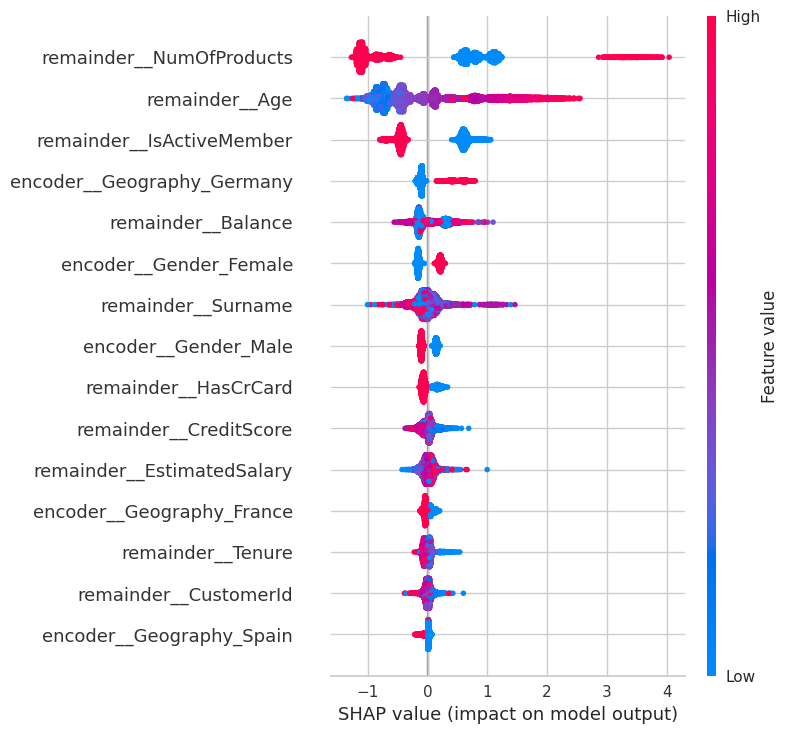

In [36]:
import shap


model = lgbm_simple

model.fit(X_train_explain, y_train)


explainer = shap.TreeExplainer(model, data=X_train_explain, feature_perturbation='interventional')
#interventional argument breaks feature dependencies and provides better estimate

shap_values = explainer.shap_values(X_test_explain, check_additivity=False )

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test_explain)

<a id = "14"></a><br>
# Submission

Let's make our submission...

In [37]:
Voting_ensemble = Voting_ensemble.fit(train_df, y)
preds_test = Voting_ensemble.predict_proba(test)[:, 1]

In [38]:
output = pd.DataFrame({'id': test.index,
                       'Exited': preds_test})
output.to_csv('submission.csv', index=False)

output.head()

,id,Exited
0,165034,0.027673
1,165035,0.864809
2,165036,0.026239
3,165037,0.237808
4,165038,0.363785


<a id = "15"></a><br>
# To do...

* Feature engineering
* More agressive tunning

<a id = "16"></a><br>
# Appendix

<a id = "17"></a><br>
# Optuna setings for different classifiers

In [39]:
#lightgbm_simple

#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 30, 500)
#    max_depth = trial.suggest_int("max_depth", 2, 12)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
#    subsample = trial.suggest_float("subsample", 0.1, 1.0)        
#    max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
#    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
#    #eval_metric = 'logloss'
#    #objective = 'binary:logistic' 



#    lgbm_classifier = LGBMClassifier(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate,
#                                     min_data_in_leaf=min_data_in_leaf, subsample=subsample,max_bin=max_bin,
#                                     feature_fraction=feature_fraction, random_state =random_state, verbose=-1)
   
    # -- Make a pipeline
#    lgbm_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#    #('smote', sm),
#    ("lgbm_classifier", lgbm_classifier)
#])


#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(lgbm_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),   cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [40]:
#lightgbm with class weight



#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 30, 500)
#    max_depth = trial.suggest_int("max_depth", 2, 12)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
#    subsample = trial.suggest_float("subsample", 0.1, 1.0)        
#    max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
#    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
#    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 10.0,log=True )
#    #eval_metric = 'logloss'
#    #objective = 'binary:logistic' 


#    lgbm_classifier = LGBMClassifier(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate,
#                                     min_data_in_leaf=min_data_in_leaf, subsample=subsample,max_bin=max_bin,scale_pos_weight=scale_pos_weight,
#                                     feature_fraction=feature_fraction, random_state =random_state, verbose=-1)
   
    # -- Make a pipeline
#    lgbm_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#    #('smote', sm),
#    ("lgbm_classifier", lgbm_classifier)
#])


    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(lgbm_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),   cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [41]:
#lightgbm with smote


#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 30, 500)
#    max_depth = trial.suggest_int("max_depth", 2, 12)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
#    subsample = trial.suggest_float("subsample", 0.1, 1.0)        
#    max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
#    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
#    #scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 100.0,log=True )
#    #eval_metric = 'logloss'
#    #objective = 'binary:logistic' 


#    lgbm_classifier = LGBMClassifier(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate,
#                                     min_data_in_leaf=min_data_in_leaf, subsample=subsample,max_bin=max_bin,
#                                     feature_fraction=feature_fraction, random_state =random_state, verbose=-1)
   
    # -- Make a pipeline
#    lgbm_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#    ('smote', sm),
#    ("lgbm_classifier", lgbm_classifier)
#])


    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(lgbm_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),   cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [42]:
#xgboost simple 

#def objective(trial):

    #n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
#    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 1, log=True)
    # defines how selective algorithm is.
#    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    

       

#    xgb_clf = XGBClassifier(alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
#                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,gamma=gamma,
#                           random_state =random_state)
   
        
     # -- Make a pipeline
#    xgb_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
    #('smote', sm),
#    ("xgb_clf", xgb_clf)
#    ])
    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(xgb_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [43]:
#xgboost with class weight
#def objective(trial):

    #n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
#    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 1, log=True)
    # defines how selective algorithm is.
#    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    
#    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 10,log=True )

       

#    xgb_clf = XGBClassifier(alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
#                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,gamma=gamma,
#                            scale_pos_weight=scale_pos_weight,
#                           random_state =random_state)
   
        
     # -- Make a pipeline
#    xgb_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
    #('smote', sm),
#    ("xgb_clf", xgb_clf)
#    ])
    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(xgb_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [44]:
#xgboost with smote

#def objective(trial):

    #n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
#    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 1, log=True)
    # defines how selective algorithm is.
#    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    

#    xgb_clf = XGBClassifier(alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
#                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,
#                            gamma=gamma, random_state =random_state)
   
        
     # -- Make a pipeline
#    xgb_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#    ('smote', sm),
#    ("xgb_clf", xgb_clf)
        
#    ])
    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(xgb_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [45]:
#hist simple

#def objective(trial):


#    params = {
#        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#        'max_iter': trial.suggest_int('max_iter', 50, 200),
#        'max_depth': trial.suggest_int('max_depth', 3, 12),
#        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1.0),
#    }
      
    

#    hst_clf = HistGradientBoostingClassifier(**params, random_state =random_state)
   
    # -- Make a pipeline
#    hst_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
        #('smote', sm),
#    ("hst_clf", hst_clf),
#    ])

    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(hst_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [46]:
#hist class weight
#def objective(trial):


#    params = {
#        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#        'max_iter': trial.suggest_int('max_iter', 50, 200),
#        'max_depth': trial.suggest_int('max_depth', 3, 12),
#        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1.0),
#    }
      
    

#    hst_clf = HistGradientBoostingClassifier(**params, random_state =random_state, class_weight = 'balanced')
   
    # -- Make a pipeline
#    hst_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#        #('smote', sm),
#    ("hst_clf", hst_clf),
#    ])

    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(hst_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [47]:
#hist smote
#def objective(trial):


#    params = {
#        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#        'max_iter': trial.suggest_int('max_iter', 50, 200),
#        'max_depth': trial.suggest_int('max_depth', 3, 12),
#        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1.0),
#    }
      
    

#    hst_clf = HistGradientBoostingClassifier(**params, random_state =random_state)
   
    # -- Make a pipeline
#    hst_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#    ('smote', sm),
#    ("hst_clf", hst_clf),
#    ])

    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(hst_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [48]:
#catboost simple


#def objective(trial):

#    cat_param = {
#        #"iterations" : trial.suggest_int("iterations", 10,500),
#        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
#        "learning_rate": trial.suggest_float("learning_rate",1e-3, 1e-2, log=True),
#        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
        
#        "depth": trial.suggest_int("depth", 2, 12),
#        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 8),

#        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
#        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"])
#    }

#    if cat_param["bootstrap_type"] == "Bayesian":
#        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif cat_param["bootstrap_type"] == "Bernoulli":
#        cat_param["subsample"] = trial.suggest_float("subsample", 0.3, 0.8)
    

    

 #   catboost_clf = CatBoostClassifier(**cat_param,random_state =random_state, logging_level='Silent')

    # -- Make a pipeline
 #   cat_pipeline = imbpipeline([
    
 #   ('tree_preprocessor', tree_preprocessor),
 #    #('smote', sm),
 #   ("catboost_clf", catboost_clf)
 #   ])
    
 #   ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
 #   score = cross_val_score(cat_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
 #   score = score.mean()
 #   return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [49]:
#catboost class weight

#def objective(trial):

#    cat_param = {
        #"iterations" : trial.suggest_int("iterations", 10,500),
#        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
#        "learning_rate": trial.suggest_float("learning_rate",1e-3, 1e-2, log=True),
#        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
        
#        "depth": trial.suggest_int("depth", 2, 12),
#        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 8),

#        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
#        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"]),
#        "scale_pos_weight" : trial.suggest_float("scale_pos_weight", 0.1, 10,log=True )

#    }

#    if cat_param["bootstrap_type"] == "Bayesian":
#        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif cat_param["bootstrap_type"] == "Bernoulli":
#        cat_param["subsample"] = trial.suggest_float("subsample", 0.3, 0.8)
    

    

#    catboost_clf = CatBoostClassifier(**cat_param,random_state =random_state, logging_level='Silent')

    # -- Make a pipeline
#    cat_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
#    ("catboost_clf", catboost_clf)
#    ])
    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(cat_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [50]:
#catboost smote
#def objective(trial):

#    cat_param = {
#        #"iterations" : trial.suggest_int("iterations", 10,500),
#        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
#        "learning_rate": trial.suggest_float("learning_rate",1e-3, 1e-2, log=True),
#        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
        
#        "depth": trial.suggest_int("depth", 2, 12),
#        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 8),

#        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
#        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"])
#    }

#    if cat_param["bootstrap_type"] == "Bayesian":
#        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif cat_param["bootstrap_type"] == "Bernoulli":
#        cat_param["subsample"] = trial.suggest_float("subsample", 0.3, 0.8)
    

    

#    catboost_clf = CatBoostClassifier(**cat_param,random_state =random_state, logging_level='Silent')

    # -- Make a pipeline
#    cat_pipeline = imbpipeline([
    
#    ('tree_preprocessor', tree_preprocessor),
#     ('smote', sm),
#    ("catboost_clf", catboost_clf)
#    ])
    
#    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(cat_pipeline, X_train, y_train, scoring= make_scorer(roc_auc_score, needs_proba=True),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

<a id = "18"></a><br>
## Different Tunning medhods for ensembling

In [51]:
#def objective(trial):
    
    
    

#    estimators = [

#        ('pipe_lgbm_simple', pipe_lgbm_simple),
#        ('pipe_lgbm_class_weight', pipe_lgbm_class_weight),
#        ('pipe_lgbm_smote', pipe_lgbm_smote),
#        ('pipe_xgb_simple', pipe_xgb_simple),
#        ('pipe_xgb_class_weight', pipe_xgb_class_weight),
#        ("pipe_xgb_smote", pipe_xgb_smote),
#        ("pipe_hst_simple", pipe_hst_simple),
#        ("pipe_hst_smote", pipe_hst_smote),
#        ("pipe_hst_class_weight", pipe_hst_class_weight),
#        ("pipe_cat_simple", pipe_cat_simple),
#        ("pipe_cat_class_weight", pipe_cat_class_weight),
#        ("pipe_cat_smote", pipe_cat_smote)

#    ]

#    C =  trial.suggest_float("C", 1e-4, 10, log=True)

     
#    stacking_clf = StackingClassifier(estimators=estimators, final_estimator= LogisticRegression(C=C))
    
#    stacking_clf.fit(X_train, y_train)

    # Calculate ROC AUC score for optimization
#    y_pred = stacking_clf.predict_proba(X_test)[:, 1]
#    auc = roc_auc_score(y_test, y_pred)
    
    
#    return auc


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=10)

In [52]:
#pipe_lgbm_simple = pipe_lgbm_simple.fit(X_train, y_train)
#pipe_lgbm_class_weight = pipe_lgbm_class_weight.fit(X_train, y_train)
#pipe_lgbm_smote = pipe_lgbm_smote.fit(X_train, y_train)
#pipe_xgb_simple = pipe_xgb_simple.fit(X_train, y_train)
#pipe_xgb_class_weight = pipe_xgb_class_weight.fit(X_train, y_train)
#pipe_xgb_smote = pipe_xgb_smote.fit(X_train, y_train)
#pipe_hst_simple = pipe_hst_simple.fit(X_train, y_train)
#pipe_hst_smote = pipe_hst_smote.fit(X_train, y_train)
#pipe_cat_simple = pipe_cat_simple.fit(X_train, y_train)



# Define the objective function for Optuna
#def objective(trial):
    # Optimize weights for each pre-tuned model
#    lg1_w = trial.suggest_float('lg1_w', 0.0, 1.0)
#    lg2_w = trial.suggest_float('lg2_w', 0.0, 1.0)
#    lg3_w = trial.suggest_float('lg3_w', 0.0, 1.0)
#    lg4_w = trial.suggest_float('lg4_w', 0.0, 1.0)
#    lg5_w = trial.suggest_float('lg5_w', 0.0, 1.0)
#    lg6_w = trial.suggest_float('lg6_w', 0.0, 1.0)
#    lg7_w = trial.suggest_float('lg7_w', 0.0, 1.0)
#    lg8_w = trial.suggest_float('lg8_w', 0.0, 1.0)
#    lg9_w = trial.suggest_float('lg8_w', 0.0, 1.0)
    
#    norm_factor =  (lg1_w + lg2_w + lg3_w + lg4_w + lg5_w + lg6_w + + lg7_w + lg8_w + lg9_w)

    # Set weights for the models
#    weights = {'lg1_w': lg1_w / norm_factor, 'lg2_w': lg2_w / norm_factor , 'lg3_w': lg3_w / norm_factor, 'lg4_w': lg4_w/ norm_factor,
#               'lg5_w': lg5_w/ norm_factor, 'lg6_w': lg6_w/ norm_factor, 'lg7_w': lg7_w/ norm_factor, 'lg8_w': lg8_w/ norm_factor, 'lg9_w': lg9_w/ norm_factor}

    # Combine predictions with the optimized weights
#    ensemble_predictions = np.average([pipe_lgbm_simple.predict_proba(X_test)[:, 1],
#                                      pipe_lgbm_class_weight.predict_proba(X_test)[:, 1],
#                                      pipe_lgbm_smote.predict_proba(X_test)[:, 1],
#                                      pipe_xgb_simple.predict_proba(X_test)[:, 1],
#                                      pipe_xgb_class_weight.predict_proba(X_test)[:, 1],
#                                      pipe_xgb_smote.predict_proba(X_test)[:, 1],
#                                      pipe_hst_simple.predict_proba(X_test)[:, 1],
#                                      pipe_hst_smote.predict_proba(X_test)[:, 1],
#                                      pipe_cat_simple.predict_proba(X_test)[:, 1]],
#                                      axis=0,
#                                      weights=[weights['lg1_w'], weights['lg2_w'], weights['lg3_w'], weights['lg4_w'],
#                                              weights['lg5_w'], weights['lg6_w'], weights['lg7_w'], weights['lg8_w'], weights['lg9_w']])

    # Calculate ROC AUC score for optimization
#    auc = roc_auc_score(y_test, ensemble_predictions)

#    return auc

# Define the Optuna study and optimize weights
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

# Print the best weights and AUC score
#best_weights = study.best_params
#best_auc = study.best_value
#print(f"Best Weights: {best_weights}")
#print(f"Best ROC AUC Score: {best_auc}")

In [53]:
# Plot feature importances using Seaborn

#def plot_feature_importances(model, feature_names, title):
#    model.importance_type = 'gain'
#    importances = model.feature_importances_
#    indices = np.argsort(importances)[::-1]
    
#    plt.figure(figsize=(10, 6))
#    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette='viridis')
#    plt.title(title, fontsize=16)
#    plt.xlabel('Feature Importance', fontsize=14)
#    plt.ylabel('Feature', fontsize=14)
#    plt.show()

#plot_feature_importances(pipe_lgbm_simple['lgbm_tunned'], X_train_explain.columns, 'LightGBM Feature Importances')